In [1]:
from numpy import array
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, LSTM
from tensorflow.keras.layers import GlobalMaxPooling1D, Bidirectional 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras import regularizers
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
import numpy as np
import re
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

#### Read Data

In [3]:
df = pd.read_excel('F:/Dropbox/work_CSIO/Matlab code/Data_samples/xsensspl8.xlsx',Sheet='Sheet1')
data=np.array(df)
print(data.shape)

(34862, 12)


In [4]:
df.head()

,ax,ay,az,p,q,r,mx,my,mz,phi,theta,psi
0,-10.737535,0.391422,-3.663906,0.658523,0.970999,1.190157,0.388630,-0.962716,0.168679,0.000000,0.000000,0.000000
1,-10.707877,0.505757,-3.693432,0.654316,0.978867,1.174472,0.388630,-0.962716,0.168679,0.000000,0.000000,0.000000
2,-10.716776,0.665346,-3.713769,0.655849,0.995880,1.156338,0.385752,-0.962422,0.173658,0.000000,0.000000,0.000000
3,-10.701850,0.711116,-3.728693,0.660809,1.002761,1.147747,0.385752,-0.962422,0.173658,1.741489,1.117280,-1.655398
4,-10.618154,0.680932,-3.602161,0.669307,1.010884,1.138853,0.385752,-0.962422,0.173658,1.747265,1.114015,-1.650832


In [5]:
# arrange the data
phiprev = []
thetaprev = []
psiprev = []
for i in range(0,data.shape[0]):
    if i == 0:
        phiprev.append(0)
        thetaprev.append(0)
        psiprev.append(0)
    else:
        phiprev.append(data[i-1,9])
        thetaprev.append(data[i-1,10])
        psiprev.append(data[i-1,11])
phiprev = np.array(phiprev)
thetaprev = np.array(thetaprev) 
psiprev = np.array(psiprev) 

In [6]:
dataX = np.column_stack((data[:,0:9],phiprev,thetaprev,psiprev))
dataY = data[:,9:12]

In [8]:
split = 10000
dataXt = dataX[:split]
dataYt = dataY[:split]
dataXv = dataX[split:]
dataYv = dataY[split:]

input_dim = dataXt.shape[1]

print("input_dim:", input_dim)
print("\nTraining Testing")
print(dataXt.shape[0],dataXv.shape[0])

input_dim: 12

Training Testing
10000 24862


# Main Model Training

In [9]:
Xphithetapsi = dataXt
Xphithetapsi = array(Xphithetapsi).reshape(Xphithetapsi.shape[0], 1, input_dim)
Yphithetapsi = dataYt

# model desing
np.random.seed(0)
inputs = Input(name='inputs',shape=[1,input_dim])
layer = LSTM(6)(inputs)
outputs = Dense(3, activation='linear')(layer)

modelphithetapsi1 = Model(inputs=[inputs],outputs=[outputs])

# Compile
modelphithetapsi1.compile(optimizer='RMSprop', loss='mean_squared_error',metrics = ['accuracy'])
modelphithetapsi1.summary()

history = modelphithetapsi1.fit(Xphithetapsi, Yphithetapsi,
                       epochs=20,
                       batch_size=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 1, 12)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 6)                 456       
_________________________________________________________________
dense (Dense)                (None, 3)                 21        
Total params: 477
Trainable params: 477
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
10000/10000 [==============================] - 6s 643us/step - loss: 2.4578 - acc: 0.4084
Epoch 2/20
10000/10000 [==============================] - 1s 80us/step - loss: 0.7902 - acc: 0.7491
Epoch 3/20
10000/10000 [==============================] - 1s 86us/step - loss: 0.1953 - acc: 0.8946
Epoch 4/20
10000/10000 [==============================] - 1s 85us/step - loss: 0.0990 - acc: 0.9075
Epoch 5

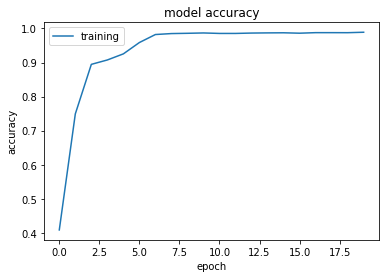

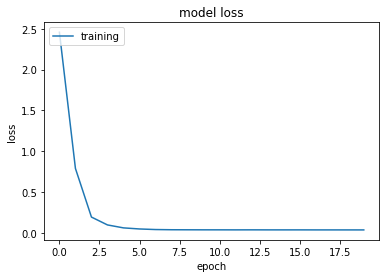

In [10]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training'], loc = 'upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training'], loc = 'upper left')
plt.show()

In [11]:
# new model for incremental learning
model = Model(inputs=[inputs],outputs=[outputs])
model.compile(optimizer='RMSprop', loss='mean_squared_error',metrics = ['accuracy'])

In [16]:
#copy weights
Wsave = modelphithetapsi1.get_weights()
model.set_weights(Wsave)
results = []

In [17]:
for j in range(0,25):
    XtestA = []
    step = 1000
    pt = step*j
    Xtestt = dataXv[pt:pt+step]
    Ytest = dataYv[pt:pt+step]
    Xtest = array(Xtestt[:,0:9])

    for i in range(0,step):
        if pt==0 and i==0:
            test_input = np.concatenate((Xtest[i,:],dataXt[split-1,9:12]))
        else:
            test_input = np.column_stack((Xtest[i,:].reshape((1,9)),Xtestt[i,9:12].reshape((1,3))))
        test_input = test_input.reshape((1, 1, input_dim))
        XtestA.append(test_input)
        test_output = model.predict(test_input)
        results.append(test_output)

    Xtest1 = array(XtestA).reshape((array(XtestA).shape[0], 1, input_dim))
    model.fit(Xtest1, Ytest, epochs=20, verbose=0, batch_size=50)

IndexError: index 862 is out of bounds for axis 0 with size 862

### for all 3 plots and RMSE

RMSE phi 0.3030827749246891
RMSE theta 0.2297624678050035
RMSE phi 0.20474642838925142
0.3030827749246891 0.2297624678050035 0.20474642838925142


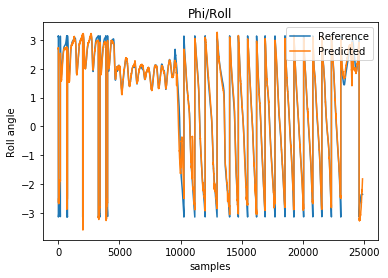

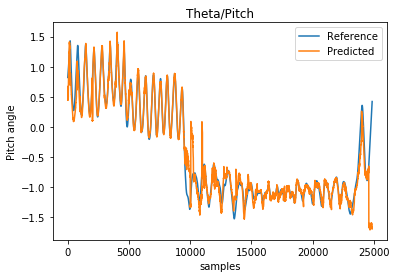

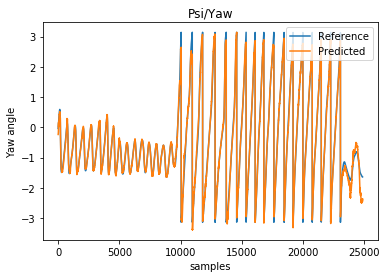

In [18]:
Yt = dataYv
test_output = np.array(results)
test_output = test_output.reshape((Yt.shape[0],3))


from sklearn.metrics import mean_squared_error
from math import sqrt
rmsephi = sqrt(mean_squared_error(Yt[:,0], test_output[:,0]))
print("RMSE phi",rmsephi)

rmsetheta = sqrt(mean_squared_error(Yt[:,1], test_output[:,1]))
print("RMSE theta",rmsetheta)

rmsepsi = sqrt(mean_squared_error(Yt[:,2], test_output[:,2]))
print("RMSE phi",rmsepsi)

print(rmsephi,rmsetheta,rmsepsi)

plt.plot(Yt[:,0])
plt.plot(test_output[:,0])
plt.title('Phi/Roll')
plt.xlabel('samples')
plt.ylabel('Roll angle')
plt.legend(['Reference', 'Predicted'], loc = 'upper right')
plt.show()

plt.plot(Yt[:,1])
plt.plot(test_output[:,1])
plt.title('Theta/Pitch')
plt.xlabel('samples')
plt.ylabel('Pitch angle')
plt.legend(['Reference', 'Predicted'], loc = 'upper right')
plt.show()

plt.plot(Yt[:,2])
plt.plot(test_output[:,2])
plt.title('Psi/Yaw')
plt.xlabel('samples')
plt.ylabel('Yaw angle')
plt.legend(['Reference', 'Predicted'], loc = 'upper right')
plt.show()